In [ ]:
Student Details

Name: Cormac Lavery

ID: 16139658

# Lab 4: Comparison of Classifiers

This notebook demonstrates how to choose the best out of a few alternative classification models by applying cross-validation and comparing the accuracy of prediction, the F1-scores and the ROC curves of the classification models.

Here we use a _modified version_ of the __seeds data set__ (see https://archive.ics.uci.edu/ml/datasets/seeds), which is one of the public UCI data sets. Each example is a seed described by a few numerical attributes. The target variable for classification (in this example) is the type of the seed, which can be either 1 or 0. Class 1 are the seeds of a particular type that, we can assume, is important to learn to predict correctly, while class 0 are all other seeds.

In this example, we use 5-fold cross-validation. Empirical evidence suggests that 10 folds are probably the best choice for cross-validation, i.e. 10-fold cross-validation. However, since this data set is relatively small, and 1/10 of it is only 21 examples, it is sensible to use larger folds for testing. Thus, we demonstrate the comparison of classifiers with 5-fold cross-validation.

The code in this notebook was originally inspired by the example at https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html.

## A. Preparation

### Import Python modules

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

from sklearn.model_selection import StratifiedKFold
from sklearn.grid_search import GridSearchCV

from scipy import interp

### Import evaluation and plotting functions

In [49]:
%run ./Lab4_Functions_16139658.ipynb

### Load and prepare the dataset for training and evaluating a classifier
Feel free to apply any other pre-processing technique at this point.

In [50]:
lab4_df = pd.read_csv("./loans_et4.csv")
lab4_df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.820833,0.647917,0.777083,0.797917,0.137500,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.691667
std,0.383892,0.478118,1.020815,0.401973,0.344734,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.462287
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,0.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000


In [51]:
# target attribute
target = lab4_df['Loan_Status']

# predictor attributes
predictors = lab4_df.drop('Loan_Status', axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute 'type' is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

### Prepare an array of 100 equally spaced false-positive-rate values between 0 and 1
To be used as an x-axis in ROC curve plots.

In [52]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

## B. Evaluation and Comparison of Classifiers

### Train a Probablistic SVM Classifier

In [53]:
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(probability=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM, f1_scores_SVM, tprs_SVM, aucs_SVM, precision_SVM, recall_SVM, thresholds_SVM = evaluate_classifier(folds=5, 
                                                                        p=predictors, t=target, 
                                                                        classifier=SVM_classifier, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

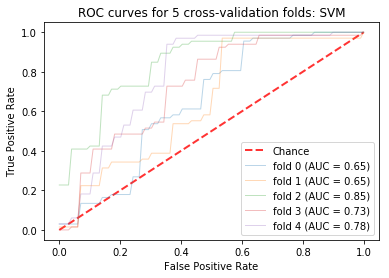

In [54]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

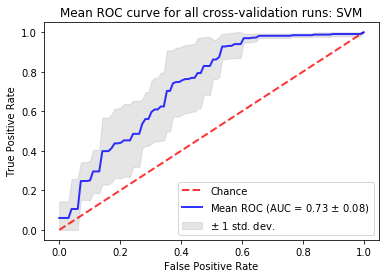

In [55]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

### Train a Naive Bayes Classifier

In [56]:
# Create a Naive Bayes classifier object with default parameters (note: Naive Bayes is a probabilistic classifier by default)
NB_classifier = GaussianNB()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_NB, f1_scores_NB, tprs_NB, aucs_NB, precision_NB, recall_NB, thresholds_NB = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=NB_classifier, 
                                                                    mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

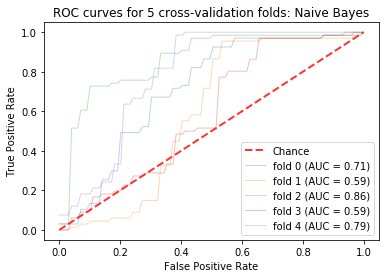

In [57]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

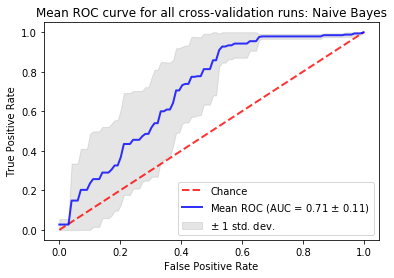

In [58]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

### Train a Logistic Regression Classifier

In [59]:
# Create a Logistic Regression classifier object with default parameters (note: Naive Bayes is a probabilistic classifier by default)
LR_classifier = LogisticRegression()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_LR, f1_scores_LR, tprs_LR, aucs_LR, precision_LR, recall_LR, thresholds_LR = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=LR_classifier, 
                                                                    mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

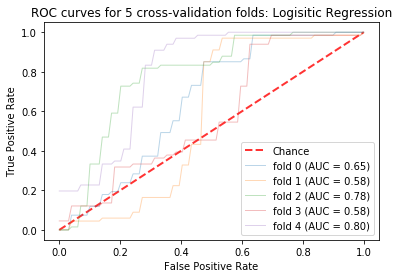

In [60]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_LR, aucs_LR, 'Logisitic Regression')

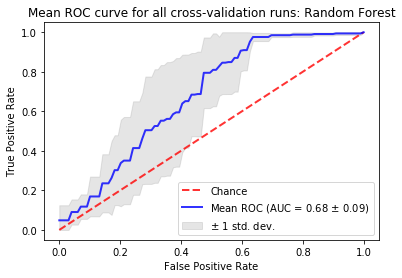

In [61]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_LR, aucs_LR, 'Random Forest')

### Compare All Trained Classifiers

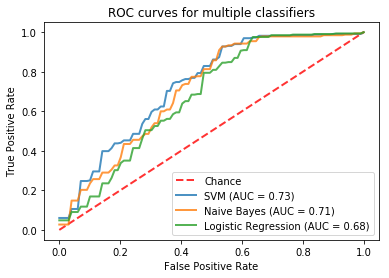

In [62]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM, axis=0), np.mean(tprs_NB, axis=0), np.mean(tprs_LR, axis=0))), 
                              np.array([np.mean(aucs_SVM), np.mean(aucs_NB), np.mean(tprs_LR)]), 
                              np.array(['SVM', 'Naive Bayes', 'Logistic Regression']))

In [63]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB, 'Logistic Regression' : accuracies_LR})

In [64]:
accuracies_df.describe()

,Logistic Regression,Naive Bayes,SVM
count,5.000000,5.000000,5.000000
mean,0.808403,0.791670,0.808403
std,0.029567,0.053465,0.029567
min,0.778947,0.715789,0.778947
25%,0.783505,0.762887,0.783505
50%,0.812500,0.804124,0.812500
75%,0.814433,0.822917,0.814433
max,0.852632,0.852632,0.852632


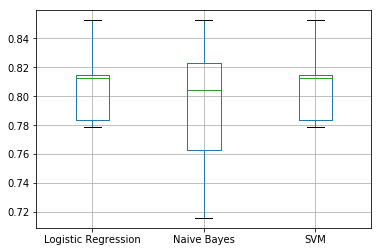

In [65]:
accuracies_df.boxplot()

In [66]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'SVM' : f1_scores_SVM, 'Naive Bayes' : f1_scores_NB, 'Logistic Regression' : f1_scores_LR})

In [67]:
f1_scores_df.describe()

,Logistic Regression,Naive Bayes,SVM
count,5.000000,5.000000,5.000000
mean,0.876278,0.860583,0.876278
std,0.017193,0.036598,0.017193
min,0.860927,0.808511,0.860927
25%,0.860927,0.839161,0.860927
50%,0.878378,0.872483,0.878378
75%,0.878378,0.882759,0.878378
max,0.902778,0.900000,0.902778


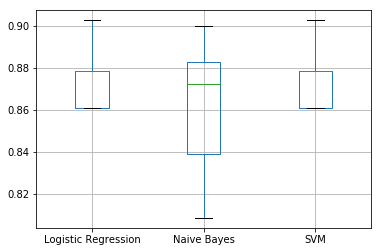

In [68]:
f1_scores_df.boxplot()

#### Conclusion

For the models we have created we can see that SVM and Logistic regression have identical f1, accuracy and AUC performances (mean ~87%) while Naive Bayes does occasionally outperform on accuracy the LR and SVM algorithms have a higher average accuracy. 

Between Logsistic regression and SVM we can conclude that SVM is more skillful as it's mean ROC curve is better. To truly seperate which performs better we will need to examine the precision-recall performance of our classifiers

# Task 3
We will now attempt to improve our SVM model with the aim of minimising false positives (i.e. high precision). We will do this by utilising the GridSearch CV class to explore different values for a number of Hyper parameters which contribute to this models performance. The hyper parameters will we will explore are: 
- Kernel
This selects the type of hyperplane used to seperate the data
- Gamma
The higher this is the more exactly it attempts to fit the data (higher values could lead ot overfitting)
- C
This parameter decides how much the model should preserve smooth boundaries over missclassifying samples



In [86]:
# scorers method from https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

param_grid = {
    'kernel' : ['linear', 'rbf'],
    'gamma' : [0.1, 1, 10],
    'C' : [0.1, 1, 10, 100]
}

scorers = {
    'precision_score': make_scorer(precision_score)
}

refit_score='precision_score'

clf = svm.SVC(probability=True)
grid_search = GridSearchCV(clf, param_grid, scoring='precision', refit=refit_score, n_jobs=-1)
grid_search.fit(predictors, target)
predictions = grid_search.predict(predictors)

print('Best params for {}'.format(refit_score))
print(grid_search.best_params_)

# confusion matrix on the test data.
print('\nConfusion matrix of SVM optimized for {} on the test data:'.format(refit_score))
pd.DataFrame(confusion_matrix(target, predictions), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])

Best params for precision_score
{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}

Confusion matrix of SVM optimized for precision_score on the test data:


,pred_neg,pred_pos
neg,63,85
pos,7,325


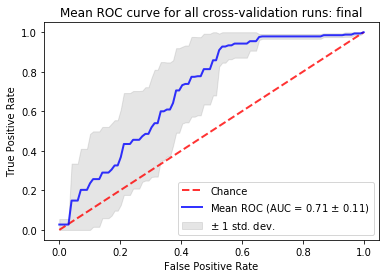

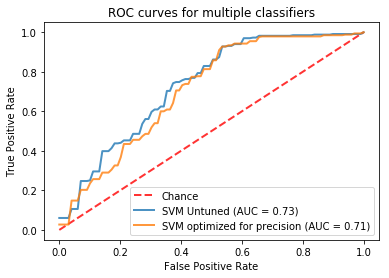

Untuned precision: 0.8283280383085068
Tuned precision: 0.8476791536061996


In [92]:
clf_final = svm.SVC(probability=True, C=0.1, gamma=0.1, kernel='linear')
accuracies_final, f1_scores_final, tprs_final, aucs_final, precision_final, recall_final, thresholds_final = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=NB_classifier, 
                                                                    mean_fpr=mean_fpr)

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_final, aucs_final, 'final')

# Compare to untuned SVM
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM, axis=0), np.mean(tprs_final, axis=0))), 
                              np.array([np.mean(aucs_SVM), np.mean(aucs_final)]), 
                              np.array(['SVM Untuned', 'SVM optimized for precision']))

print("Untuned precision: {}\nTuned precision: {}".format(str(precision_SVM.mean()),str(precision_final.mean())))